In [4]:
import os
import requests
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [5]:
with open('idtoken.json', 'r', encoding='utf-8') as f:
    idtoken = json.load(f)

idToken = idtoken['idToken']
# ulr = 'https://api.jquants.com/v1/prices/daily_quotes'

In [19]:

# パラメータとして銘柄コード、取得開始日、終了日などを指定
stock_code = "7203"  # トヨタ自動車の例
start_date = "2016-01-01"
end_date = "2020-12-31"
url = f"https://api.jquants.com/v1/prices/daily_quotes?code={stock_code}&from={start_date}&to={end_date}"

# ヘッダーにAPIキーを付与
headers = {'Authorization': 'Bearer {}'.format(idToken)}

# リクエスト送信
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # JSONレスポンスを取得
    data = response.json()
    # 返されるJSONデータのキーに合わせて変換
    # 例: {"daily_quotes": [{"date": "...", "open": ..., "high": ..., "low": ..., "close": ..., "volume": ...}, ...]}
    if "daily_quotes" in data:
        df = pd.DataFrame(data["daily_quotes"])
        print("データ取得成功")
        print(df.head())
    else:
        print("想定するデータキー 'daily_quotes' が見つかりません:", data)
else:
    print("APIアクセスに失敗:", response.status_code, response.text)

データ取得成功
         Date   Code    Open    High     Low   Close UpperLimit LowerLimit  \
0  2016-01-04  72030  7400.0  7495.0  7325.0  7337.0          0          0   
1  2016-01-05  72030  7268.0  7293.0  7200.0  7226.0          0          0   
2  2016-01-06  72030  7220.0  7259.0  7021.0  7083.0          0          0   
3  2016-01-07  72030  7022.0  7057.0  6895.0  6898.0          0          0   
4  2016-01-08  72030  6798.0  7016.0  6763.0  6864.0          0          0   

       Volume  TurnoverValue  AdjustmentFactor  AdjustmentOpen  \
0   9165700.0   6.764174e+10               1.0          1480.0   
1  10405700.0   7.535486e+10               1.0          1453.6   
2  10349700.0   7.360876e+10               1.0          1444.0   
3  14845500.0   1.033144e+11               1.0          1404.4   
4  16008200.0   1.103502e+11               1.0          1359.6   

   AdjustmentHigh  AdjustmentLow  AdjustmentClose  AdjustmentVolume  
0          1499.0         1465.0           1467.4       

In [20]:

# 例としてdfは以下のカラムを持つとする: date, open, high, low, close, volume
# df = ... (前ステップで取得、整形済み)

# 日付でソートしておく
df = df.sort_values("Date").reset_index(drop=True)

# 欠損値の確認
print("欠損値数:\n", df.isnull().sum())

# 欠損値補間例: 
# ここではOHLCVに欠損があった場合、前日値で補間(前方フィル)する例を示す
df[['Open','High','Low','Close','Volume']] = df[['Open','High','Low','Close','Volume']].ffill()

# 再度欠損値確認
print("欠損値補間後:\n", df.isnull().sum())

# 異常値チェック: 
# 1) 例えばvolumeが負になったり、極端に大きすぎる値がないかを確認
# 基本的には出来高が負になることはありえないので、それをチェック
if (df['Volume'] < 0).any():
    # volumeが負の行を出力して、対処
    print("負の出来高が検出されました。対象行:\n", df[df['Volume'] < 0])
    # 負の出来高は欠損として扱い、補間するか、その行を削除
    df.loc[df['Volume'] < 0, 'Volume'] = np.nan
    df['Volume'] = df['Volume'].ffill()

# 2) 価格の異常値チェック: 
# 極端なスパイク（過去平均値から10σ以上離れるような値）がないか確認
# まずはclose価格について標準偏差ベースで簡易チェック

mean_close = df['Close'].mean()
std_close = df['Close'].std()
threshold = mean_close + 10 * std_close  # 極端な閾値の例

outliers = df[df['Close'] > threshold]
if not outliers.empty:
    print("異常な高値が検出されました:", outliers)
    # 対策例: 異常値を直前の値で補間する
    # 実際にはビジネス的な判断が必要
    for idx in outliers.index:
        if idx > 0:
            df.at[idx, 'Close'] = df.at[idx-1, 'Close']  # 前日値で補間

# ロー、ハイ、オープンについても同様の処理が可能
# 適宜、異常値の定義や処理法はビジネスロジックに合わせる

print("異常値処理後のデータプレビュー:")
print(df.head())


欠損値数:
 Date                0
Code                0
Open                1
High                1
Low                 1
Close               1
UpperLimit          0
LowerLimit          0
Volume              1
TurnoverValue       1
AdjustmentFactor    0
AdjustmentOpen      1
AdjustmentHigh      1
AdjustmentLow       1
AdjustmentClose     1
AdjustmentVolume    1
dtype: int64
欠損値補間後:
 Date                0
Code                0
Open                0
High                0
Low                 0
Close               0
UpperLimit          0
LowerLimit          0
Volume              0
TurnoverValue       1
AdjustmentFactor    0
AdjustmentOpen      1
AdjustmentHigh      1
AdjustmentLow       1
AdjustmentClose     1
AdjustmentVolume    1
dtype: int64
異常値処理後のデータプレビュー:
         Date   Code    Open    High     Low   Close UpperLimit LowerLimit  \
0  2016-01-04  72030  7400.0  7495.0  7325.0  7337.0          0          0   
1  2016-01-05  72030  7268.0  7293.0  7200.0  7226.0          0          0   
2  

In [21]:
# 特徴量エンジニアリング

# dfは date, open, high, low, close, volume 列を持ち、日付順にソート済みとする
# date列をインデックスに設定（任意）
df = df.set_index('Date')

# 1. リターン値の算出（対数リターン or 単純リターン）
# 単純リターン
df['return'] = df['Close'].pct_change()

# 対数リターン(必要に応じて)
# df['log_return'] = np.log(df['close']).diff()

# 2. ボラティリティ指標（20日ローリング標準偏差）
df['volatility_20'] = df['return'].rolling(window=20).std()

# 3. 移動平均・移動平均乖離
df['ma_5'] = df['Close'].rolling(window=5).mean()
df['ma_20'] = df['Close'].rolling(window=20).mean()
df['ma_gap_20'] = (df['Close'] - df['ma_20']) / df['ma_20'] * 100  # 20日移動平均乖離率

# 4. RSIなどのテクニカル指標（RSI計算例：14日を想定）
# RSIは: RSI = 100 - 100/(1+RS) ここでRS = (平均上昇幅/平均下落幅)
window = 14
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)

roll_up = up.rolling(window=window).mean()
roll_down = down.rolling(window=window).mean()

rs = roll_up / roll_down
df['rsi_14'] = 100.0 - (100.0 / (1.0 + rs))

# 5. 出来高関連特徴量（20日移動平均）
df['volume_ma_20'] = df['Volume'].rolling(window=20).mean()
df['volume_change'] = df['Volume'].pct_change()

# 6. その他、例えばリターンの累積和でトレンド指標を作る
df['cumulative_return'] = (1 + df['return']).cumprod() - 1

# 欠損値が新たに発生する可能性がある（ローリング計算の初期部分など）
# 最終的に欠損は除去または前方補間、もしくは学習前処理で対処
df = df.dropna()

print(df.head(30))  # 確認用


             Code    Open    High     Low   Close UpperLimit LowerLimit  \
Date                                                                      
2016-02-02  72030  7223.0  7338.0  7216.0  7304.0          0          0   
2016-02-03  72030  7088.0  7126.0  6887.0  6900.0          0          0   
2016-02-04  72030  6760.0  6842.0  6705.0  6752.0          0          0   
2016-02-05  72030  6650.0  6677.0  6531.0  6625.0          0          0   
2016-02-08  72030  6450.0  6603.0  6325.0  6555.0          0          0   
2016-02-09  72030  6250.0  6282.0  6148.0  6154.0          0          0   
2016-02-10  72030  6170.0  6263.0  6020.0  6127.0          0          0   
2016-02-12  72030  5800.0  5915.0  5703.0  5710.0          0          0   
2016-02-15  72030  6029.0  6316.0  6012.0  6256.0          0          0   
2016-02-16  72030  6254.0  6342.0  6126.0  6250.0          0          0   
2016-02-17  72030  6150.0  6172.0  6011.0  6076.0          0          0   
2016-02-18  72030  6259.0

In [22]:
# レーニング・検証・テスト期間の分割
# 1. 学習期間(Training period): 2019-01-01 ~ 2021-12-31
train_df = df.loc['2016-01-01':'2019-12-31']

# 2. 検証期間(Validation period): 2022-01-01 ~ 2022-06-30
val_df = df.loc['2020-01-01':'2020-12-31']

# # 3. テスト期間(Test period): 2022-07-01 ~ 以降
# test_df = df.loc['2024-01-01':]

print("===== 学習期間 =====")
print(train_df.head(3), "\n", train_df.tail(3))
print("===== 検証期間 =====")
print(val_df.head(3), "\n", val_df.tail(3))
# print("===== テスト期間 =====")
# print(test_df.head(3), "\n", test_df.tail(3))

===== 学習期間 =====
             Code    Open    High     Low   Close UpperLimit LowerLimit  \
Date                                                                      
2016-02-02  72030  7223.0  7338.0  7216.0  7304.0          0          0   
2016-02-03  72030  7088.0  7126.0  6887.0  6900.0          0          0   
2016-02-04  72030  6760.0  6842.0  6705.0  6752.0          0          0   

                Volume  TurnoverValue  AdjustmentFactor  ...  \
Date                                                     ...   
2016-02-02   7306900.0   5.328787e+10               1.0  ...   
2016-02-03  14168800.0   9.861066e+10               1.0  ...   
2016-02-04  10656700.0   7.215051e+10               1.0  ...   

            AdjustmentVolume    return  volatility_20    ma_5    ma_20  \
Date                                                                     
2016-02-02        36534500.0 -0.004769       0.027412  7121.4  6886.45   
2016-02-03        70844000.0 -0.055312       0.029944  7125.2  6

In [23]:
# データの標準化
scaling_features = [
    'return', 
    'volatility_20', 
    'ma_5', 
    'ma_20', 
    'ma_gap_20', 
    'rsi_14', 
    'Volume', 
    'volume_ma_20', 
    'volume_change'
]

scaler = StandardScaler()

# 学習データでfit
scaler.fit(train_df[scaling_features])

# 学習データを変換
train_df[scaling_features] = scaler.transform(train_df[scaling_features])

# テストデータを変換 (fitはしない)
val_df[scaling_features] = scaler.transform(val_df[scaling_features])
test_df[scaling_features] = scaler.transform(test_df[scaling_features])

/tmp/ipykernel_209/371309729.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[scaling_features] = scaler.transform(train_df[scaling_features])
/tmp/ipykernel_209/371309729.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[scaling_features] = scaler.transform(val_df[scaling_features])


In [24]:
train_df.columns

Index(['Code', 'Open', 'High', 'Low', 'Close', 'UpperLimit', 'LowerLimit',
       'Volume', 'TurnoverValue', 'AdjustmentFactor', 'AdjustmentOpen',
       'AdjustmentHigh', 'AdjustmentLow', 'AdjustmentClose',
       'AdjustmentVolume', 'return', 'volatility_20', 'ma_5', 'ma_20',
       'ma_gap_20', 'rsi_14', 'volume_ma_20', 'volume_change',
       'cumulative_return'],
      dtype='object')

In [25]:
features = ['return', 'volatility_20', 'ma_5', 'ma_20', 'rsi_14', 'volume_ma_20']  # 適宜拡張
X_train = train_df[features].values  # ndarrayに変換

In [26]:
# 1. IsolationForestインスタンス作成
iso_forest = IsolationForest(
    n_estimators=100,       # 木の本数
    max_samples='auto',     # サンプリング数
    contamination=0.01,     # 全体の1%を異常と想定 (仮)
    random_state=42
)

# 2. モデル学習
iso_forest.fit(X_train)

# 3. 学習データに対するスコアと異常判定
score_train = iso_forest.decision_function(X_train)  # 大きいほど「正常」、小さいほど「異常」
predict_train = iso_forest.predict(X_train)          # 1: 正常, -1: 異常

# 4. スコアをDataFrameに追加して可視化や解析に利用
train_df['iso_score'] = score_train
train_df['iso_label'] = predict_train  # 1 or -1

# 5. 結果確認 (例: 異常判定された行の先頭5行)
anomalies_train = train_df[train_df['iso_label'] == -1]
print("IsolationForestが検出した異常サンプル:\n", anomalies_train.head())

IsolationForestが検出した異常サンプル:
              Code    Open    High     Low   Close UpperLimit LowerLimit  \
Date                                                                      
2016-02-03  72030  7088.0  7126.0  6887.0  6900.0          0          0   
2016-02-09  72030  6250.0  6282.0  6148.0  6154.0          0          0   
2016-02-12  72030  5800.0  5915.0  5703.0  5710.0          0          0   
2016-02-15  72030  6029.0  6316.0  6012.0  6256.0          0          0   
2016-02-19  72030  6050.0  6086.0  5961.0  5999.0          0          0   

              Volume  TurnoverValue  AdjustmentFactor  ...  volatility_20  \
Date                                                   ...                  
2016-02-03  2.049347   9.861066e+10               1.0  ...       2.686897   
2016-02-09  2.928250   1.069947e+11               1.0  ...       3.108199   
2016-02-12  4.649331   1.340504e+11               1.0  ...       3.407675   
2016-02-15  3.135790   1.102958e+11               1.0  ...  

/tmp/ipykernel_209/2442565384.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['iso_score'] = score_train
/tmp/ipykernel_209/2442565384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['iso_label'] = predict_train  # 1 or -1


In [27]:
train_df.columns

Index(['Code', 'Open', 'High', 'Low', 'Close', 'UpperLimit', 'LowerLimit',
       'Volume', 'TurnoverValue', 'AdjustmentFactor', 'AdjustmentOpen',
       'AdjustmentHigh', 'AdjustmentLow', 'AdjustmentClose',
       'AdjustmentVolume', 'return', 'volatility_20', 'ma_5', 'ma_20',
       'ma_gap_20', 'rsi_14', 'volume_ma_20', 'volume_change',
       'cumulative_return', 'iso_score', 'iso_label'],
      dtype='object')

In [28]:
# 検証データに対するスコアと異常判定
X_val = val_df[features].values  # ndarrayに変換
score_val = iso_forest.decision_function(X_val)  # 大きいほど「正常」、小さいほど「異常」
predict_val = iso_forest.predict(X_val)          # 1: 正常, -1: 異常

# 4. スコアをDataFrameに追加して可視化や解析に利用
val_df['iso_score'] = score_val
val_df['iso_label'] = predict_val  # 1 or -1

# 5結果確認 (例: 異常判定された行の先頭5行)
anomalies_val = val_df[val_df['iso_label'] == -1]
print("IsolationForestが検出した異常サンプル:\n", anomalies_val.head())

IsolationForestが検出した異常サンプル:
              Code    Open    High     Low   Close UpperLimit LowerLimit  \
Date                                                                      
2020-04-06  72030  6230.0  6634.0  6172.0  6580.0          0          0   

              Volume  TurnoverValue  AdjustmentFactor  ...  volatility_20  \
Date                                                   ...                  
2020-04-06  1.001025   6.813357e+10               1.0  ...       4.715105   

                ma_5     ma_20  ma_gap_20    rsi_14  volume_ma_20  \
Date                                                                
2020-04-06 -0.413484 -0.310352    0.61473  0.445355      2.053486   

            volume_change  cumulative_return  iso_score  iso_label  
Date                                                                
2020-04-06       0.687427          -0.103176  -0.002978         -1  

[1 rows x 26 columns]


/tmp/ipykernel_209/3905964428.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['iso_score'] = score_val
/tmp/ipykernel_209/3905964428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['iso_label'] = predict_val  # 1 or -1


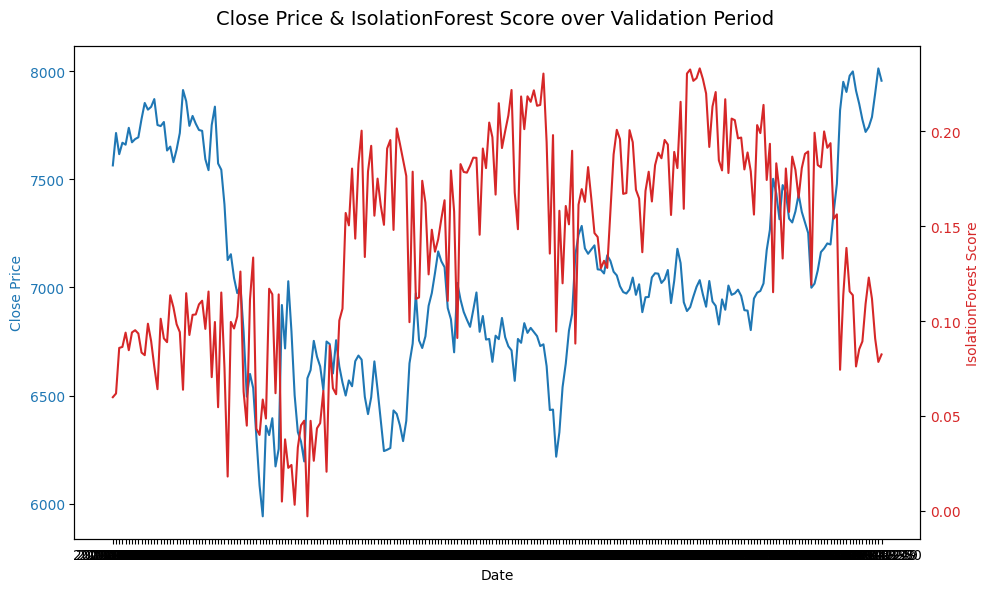

In [29]:
import matplotlib.pyplot as plt

# df_val: 検証期間のDataFrame（インデックス: DateTimeIndex）
# 例: df_valには "close" 列 (終値) と "iso_score" 列 (IsolationForestスコア) が含まれているとします。

# FigureとAxesを準備
fig, ax1 = plt.subplots(figsize=(10, 6))

# 1. 左側のY軸に終値をプロット
color_close = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color_close)
ax1.plot(val_df.index, val_df['Close'], color=color_close, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color_close)

# 2. 右側のY軸にIsolationForestスコアをプロット
ax2 = ax1.twinx()  # 2つ目のAxesを同じX軸で共有
color_score = 'tab:red'
ax2.set_ylabel('IsolationForest Score', color=color_score)
ax2.plot(val_df.index, val_df['iso_score'], color=color_score, label='Iso Score')
ax2.tick_params(axis='y', labelcolor=color_score)

# タイトルやレイアウトの設定
fig.suptitle('Close Price & IsolationForest Score over Validation Period', fontsize=14)
fig.tight_layout()

plt.show()


In [30]:
val_df.to_csv('val_df.csv')